这是我对于Unet和attention_YNet的尝试，试着把Ynet用到的处理方式应用到Unet上。

这是第一部分,包含了:
基础导入和工具函数
图像处理类(填充/还原)
数据集类
数据加载器创建函数

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet



In [ ]:
train_data, test_data = prepare_dataset("Lucchi++") # Lucchi++ /  Kasthuri++ / VNC
PATCH_SIZE = 128 #这个暂时不需要理会，和下面的内容没关系
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

In [3]:
from functions.data import SegmentationDataset

# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=128,                # 可选：patch大小，默认128
    stride=64,                     # 可选：滑动步长，默认64
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

# test_dataset= SegmentationDataset(
#     data_list=train_data,          # 必需：数据列表
#     patch_size=128,                # 可选：patch大小，默认128
#     stride=64,                     # 可选：滑动步长，默认64
#     transform=None                 # 可选：数据增强转换，默认None
# )


数据集信息:
总样本数: 46750
图像块大小: 128x128
滑动步长: 64
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 128, 128])
掩码块形状: torch.Size([1, 128, 128])

显示图片的patches: mask1055.png
原图路径: dataset\Kasthuri++\Train_In\mask1055.png
对应的Mask路径: dataset\Kasthuri++\Train_Out\mask1055.png
图片索引: 24


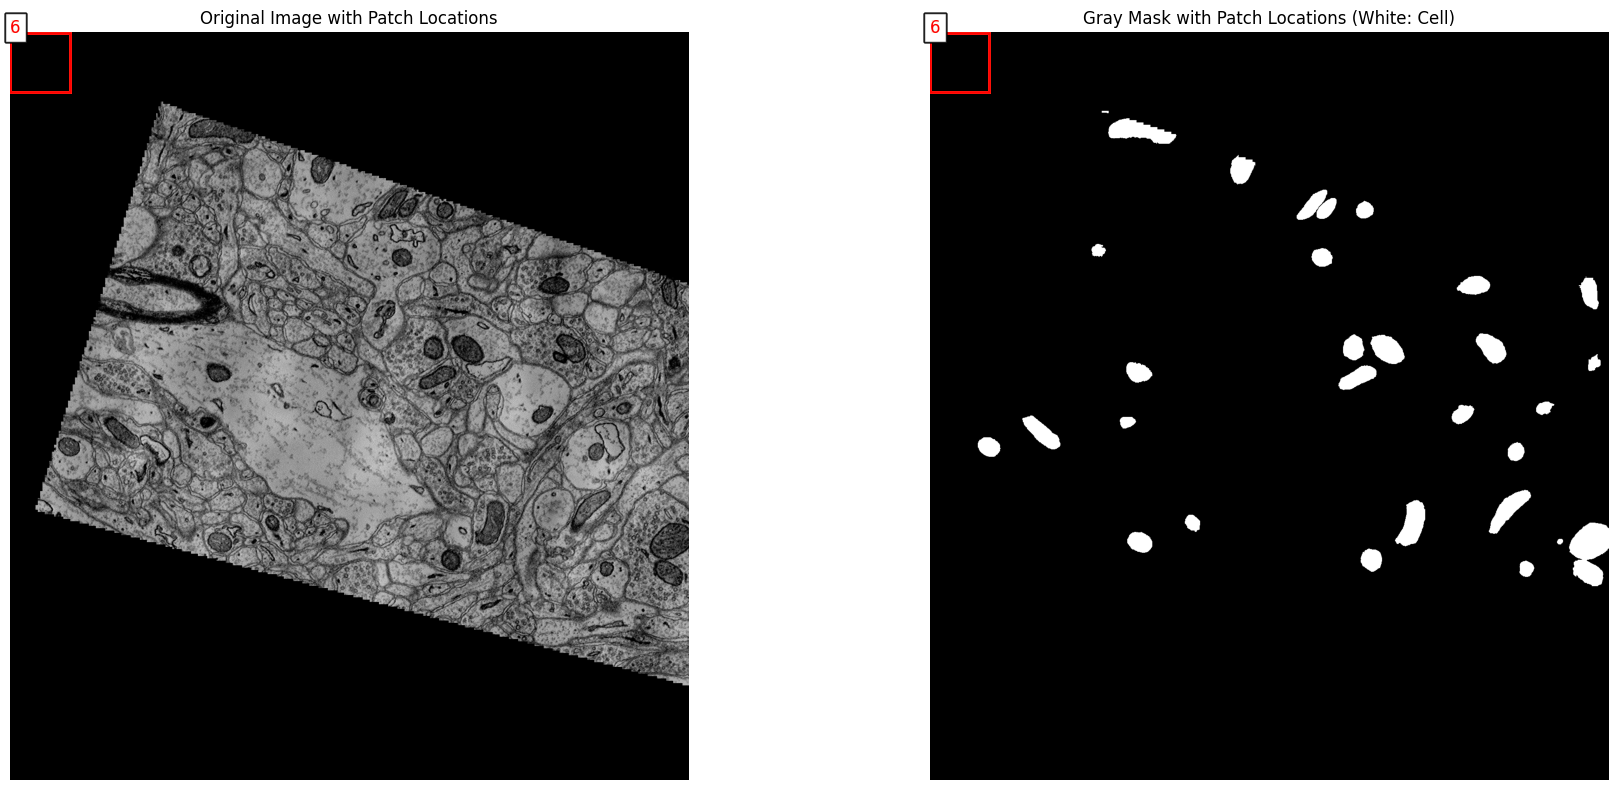

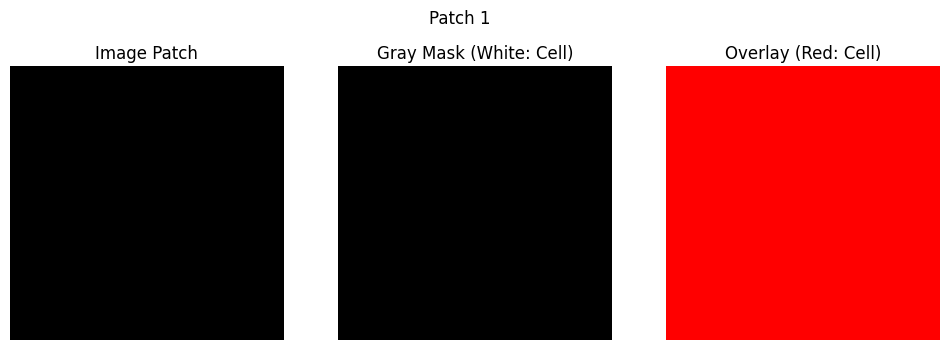

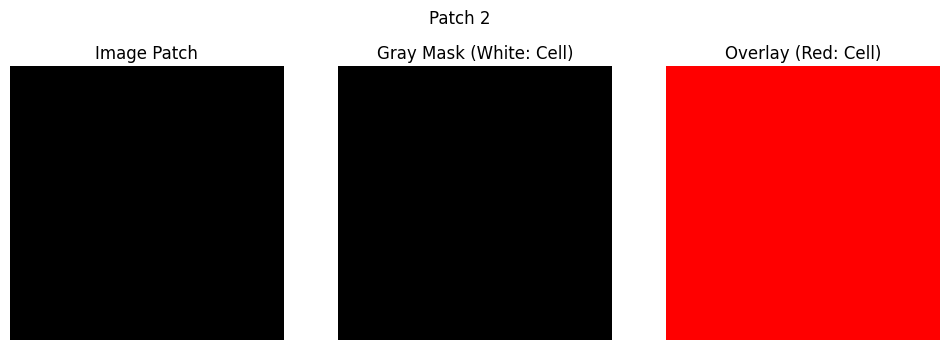

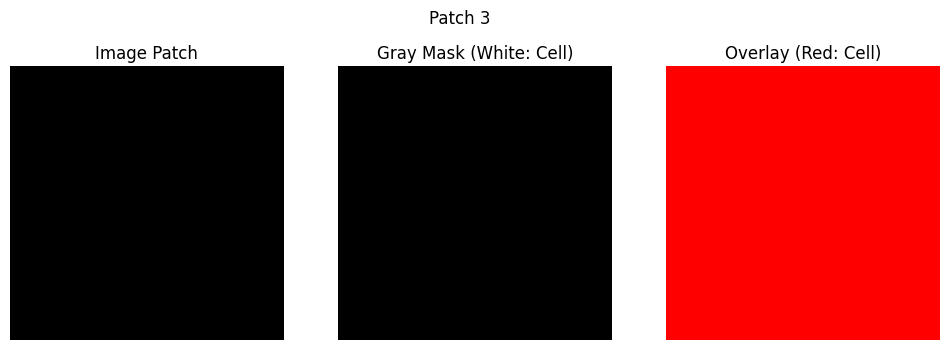

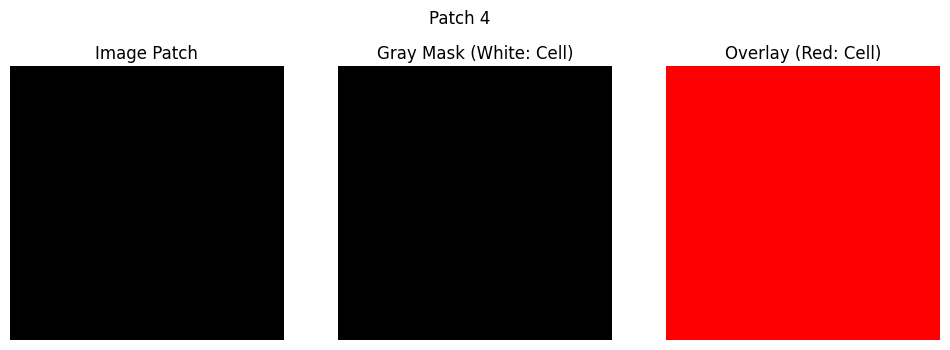

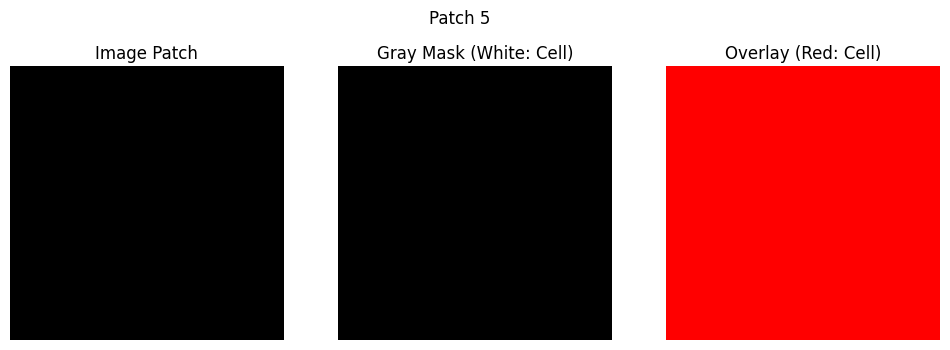

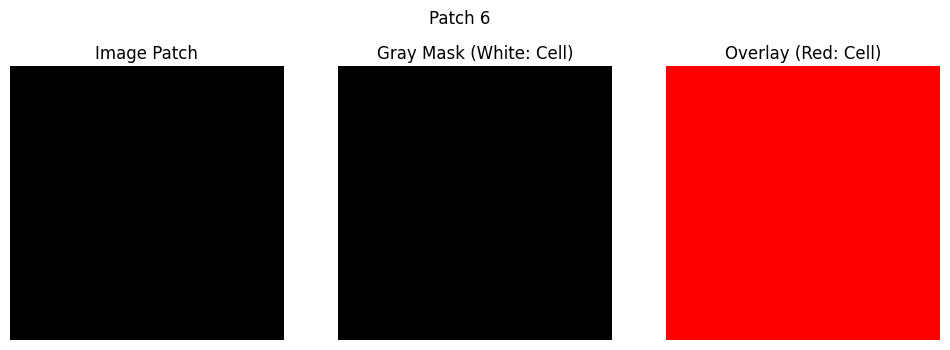

In [4]:
# 打印数据集基本信息
train_dataset.print_dataset_info()

# 随机查看几张图片的patches
train_dataset.visualize_random_images(num_images=1, patches_per_image=6)



In [5]:
# Add reconstruction function
from functions.model import reconstruct_from_patches

# Training function
from functions.model import train_model

# Inference function
from functions.model import predict


In [6]:
# 加载训练好的分割模型
from functions.model import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "simple_unet_segmentation.pth"
model = load_model(model_path, num_classes, device)

f:\github\segment-anything-2\functions\model.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [7]:
# Load the selected image and mask
image, image_path = train_dataset.read_image(idx = 1)

In [8]:
# 获取预测的mask
predicted_mask = predict(model, image_path)

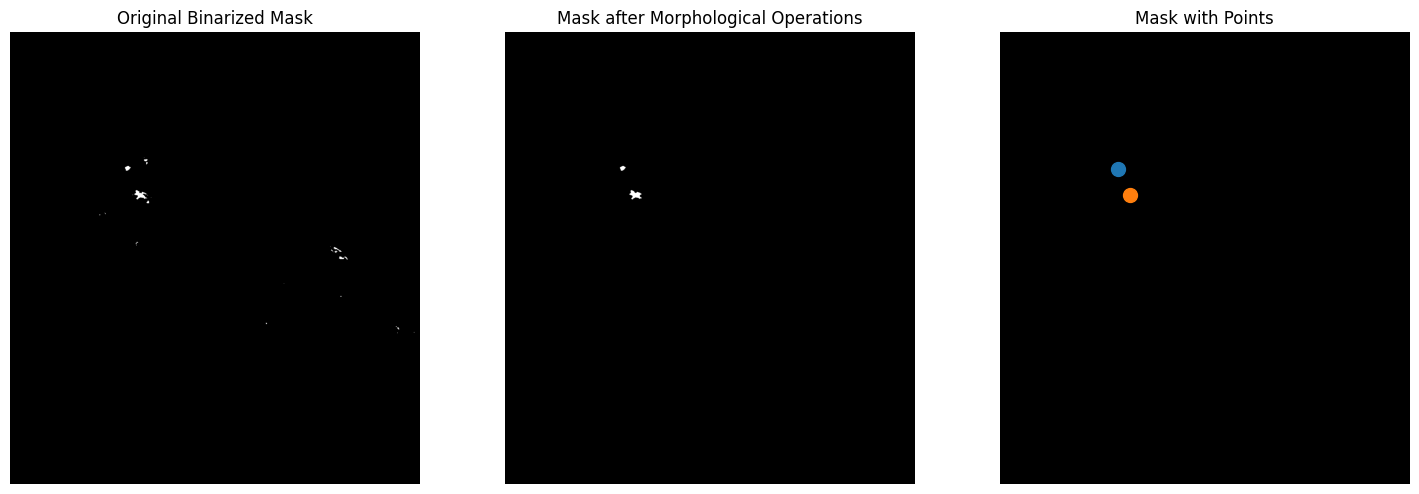

f:\github\segment-anything-2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

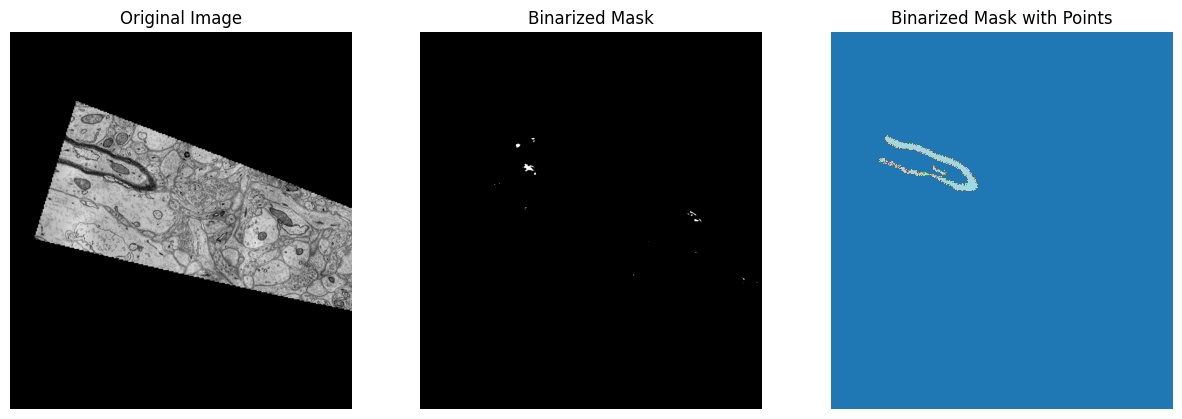

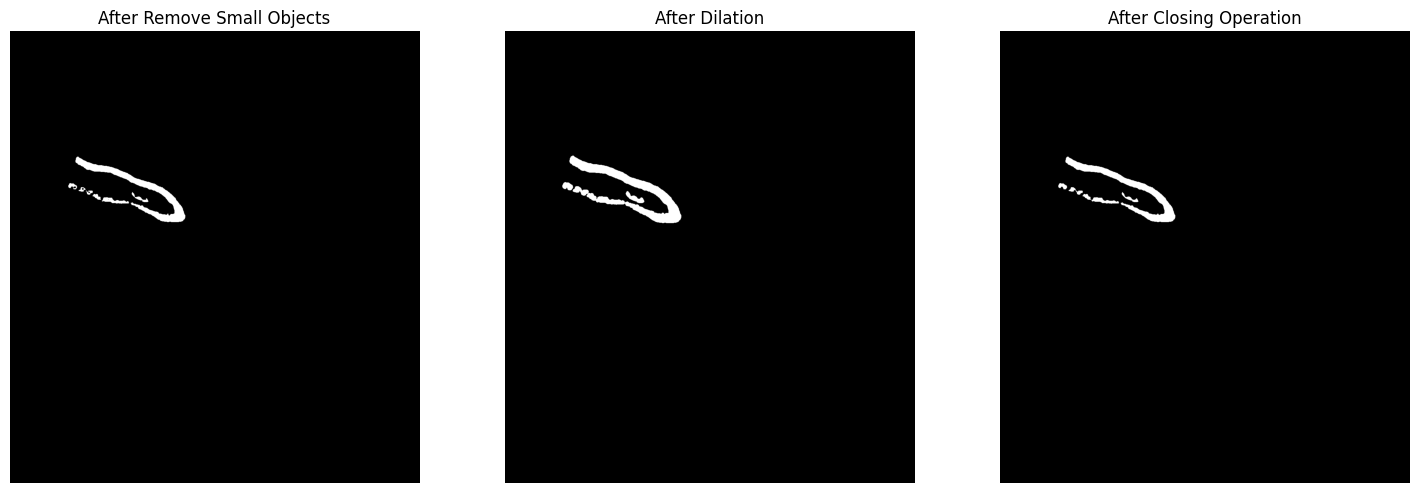

In [9]:
from functions.samPrediction import main_prediction_process

main_prediction_process(image=image, predicted_mask=predicted_mask)